In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops

import helper_functions.fitMetrics as fitMetrics
import helper_functions.displayFunctions as display
import helper_functions.homogeneityMetrics as homogeneity

# Matching Box and Segment

In [2]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('data/experiment_boxes.csv')

## Visualizing Box and Segment

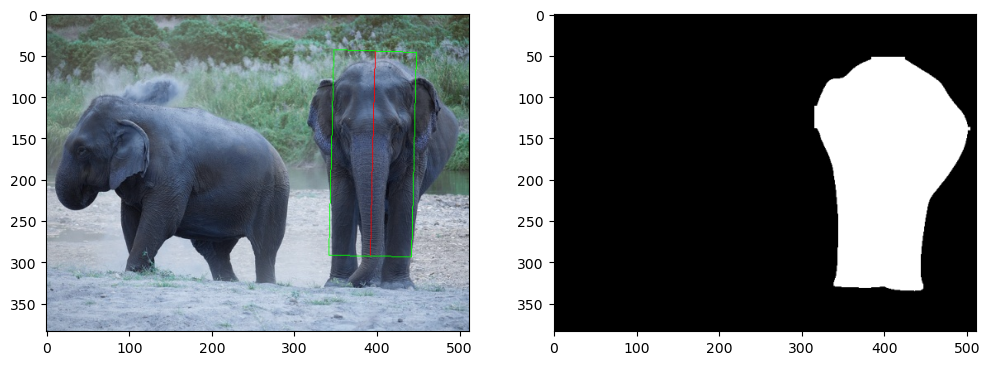

In [3]:
# image_name = 'MIRFLICKR25 - im12013.jpg' # 1 element
image_name = 'COCO - 000000372250.jpg'     # 2 elements
# image_name = 'CAT2000 -195.jpg'            # 0 elements
row_idx = 2

mask = results[image_name].masks[0].data.cpu().numpy()[0]
mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]))

image = cv2.imread('images/images_nat/' + image_name)

df_image = df[df['file_name'] == image_name]
row = df_image.iloc[row_idx]

display.drawBB(image, row)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(mask, cmap='gray')
plt.show()


## Match bounding box with object detection segment

Calculating Intersection Over Union (IOU) and Dice Score.

**Intersection Over Union**
$$\frac{\text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask} - \text{Area of Intersection}}$$

**Dice Score**
$$\frac{2 \times \text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask}}$$


In [4]:
def get_od_match_row(row, predictions):
    matches = []
    for i in range(len(predictions[row['file_name']])):
        points = display.getBBPoints(row)
        mask = predictions[row['file_name']].masks[i].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[row['file_name']].orig_shape[1], predictions[row['file_name']].orig_shape[0]))

        iou = fitMetrics.intersection_over_union(mask, points)
        dice_score = fitMetrics.dice_score(mask, points)

        detected_class = predictions[row['file_name']].names[int(predictions[row['file_name']].boxes.cls[i])]
        confidence_score = float(predictions[row['file_name']].boxes.conf[i])       
        
        matches.append((i, dice_score, iou, detected_class, confidence_score))

    if len(matches) == 0:
        matches.append((-1, 0.0, 0.0, 'None', 0.0))

    matches = sorted(matches, key=lambda x: x[2], reverse=True)

    return {
        'match_id': matches[0][0],
        'dice_score': matches[0][1],
        'iou': matches[0][2],
        'detected_class': matches[0][3],
        'confidence_score': matches[0][4]
    }

get_od_match_row(row, results)


{'match_id': 0,
 'dice_score': 0.7748471528108503,
 'iou': 0.62610836134565,
 'detected_class': 'elephant',
 'confidence_score': 0.9661673307418823}

## Match the whole dataset

In [5]:
compute = True

def get_od_matches(df, predictions):
    box_id = []
    matches = []
    experiments = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['file_name'] not in predictions:
            continue

        box_id.append(row['Index'])
        matches.append(get_od_match_row(row, predictions))
        experiments.append(row['experiment'])

    matches = pd.DataFrame(matches)
    matches.insert(0, 'box_id', box_id)
    matches.insert(6, 'experiment', experiments)

    return matches

if compute:
    od_matches = get_od_matches(df, results)
    od_matches.to_csv('data_out/object_detection/box_matches.csv')
else:
    od_matches = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)
od_matches

100%|██████████| 39254/39254 [04:43<00:00, 138.59it/s]


,box_id,match_id,dice_score,iou,detected_class,confidence_score,experiment
0,0,0,0.145687,0.078124,person,0.898828,2
1,1,-1,0.000000,0.000000,None,0.000000,2
2,2,2,0.618767,0.442655,chair,0.604875,2
3,3,-1,0.000000,0.000000,None,0.000000,2
4,4,-1,0.000000,0.000000,None,0.000000,2
...,...,...,...,...,...,...,...
39249,39249,0,0.069947,0.035430,person,0.858416,2
39250,39250,0,0.866125,0.743869,bowl,0.420610,2
39251,39251,0,0.000000,0.000000,boat,0.433775,2
39252,39252,0,0.000000,0.000000,person,0.786977,2


# Homogeneity Analysis



In [6]:
def calculate_homogeneity(row, boxes, predictions):
    # Loading image and mask
    box_row = boxes.iloc[int(row['box_id'])]
    img_orig = cv2.cvtColor(cv2.imread(display.getImgPath(box_row['file_name'])), cv2.COLOR_BGR2RGB)
    mask = predictions[box_row['file_name']].masks[row['match_id']].data.cpu().numpy()[0]
    mask = cv2.resize(mask, (predictions[box_row['file_name']].orig_shape[1], predictions[box_row['file_name']].orig_shape[0]))

    # Cropping image and mask
    mask = display.crop_image(mask, box_row)
    img = display.crop_image(img_orig, box_row)

    # Inverting mask
    mask = np.where(mask == 0, 1, 0)

    """
    Calculating homogeneity
    """
    glcm = homogeneity.glcm(img, mask)
    otsu = homogeneity.otsus_method(img_orig, mask, box_row)
    rms = homogeneity.rms(img, mask)
    edge_density = homogeneity.edge_density(img_orig, mask, box_row)

    return {
        'glcm': glcm,
        'otsu': otsu,
        'rms': rms,
        'edge_density': edge_density
    }

row = od_matches.iloc[80]

hom = calculate_homogeneity(row, df, results)

print(f'Homogeneity: {hom}')

Homogeneity: {'glcm': 0.071897058338205, 'otsu': 0.7190707725553754, 'rms': 42.56728516454071, 'edge_density': 0.21429857734557897}


## Calculate homogeneity for all dataset

In [ ]:
def get_homogeneity_dataset(matches, boxes, predictions):
    box_ids = []
    glcms = []
    otsus = []
    rmses = []
    edge_densities = []
    dice_scores = []
    ious = []

    exceptions = 0

    for _, row in tqdm(matches.iterrows(), total=len(matches)):

        if row['dice_score'] > 0.0:
            try:
                homogeneities = calculate_homogeneity(row, boxes, predictions)
                glcms.append(homogeneities['glcm'])
                otsus.append(homogeneities['otsu'])
                rmses.append(homogeneities['rms'])
                edge_densities.append(homogeneities['edge_density'])
            except:
                exceptions += 1
                continue
            box_ids.append(row['box_id'])
            dice_scores.append(row['dice_score'])
            ious.append(row['iou'])

    hom = pd.DataFrame({
        'box_id': box_ids,
        'glcm': glcms,
        'otsu': otsus,
        'root_mean_squared': rmses,
        'edge_density': edge_densities,
        'dice_score': dice_scores,
        'iou': ious
    })

    print(f'Exceptions: {exceptions}')

    return hom

compute = True

if compute:
    homogeneities_df = get_homogeneity_dataset(od_matches, df, results)
    homogeneities_df.to_csv('data_out/object_detection/homogeneities.csv')
else:
    homogeneities_df = pd.read_csv('data_out/object_detection/homogeneities.csv', index_col=0)

homogeneities_df

  9%|▊         | 3412/39254 [00:23<03:16, 181.96it/s]

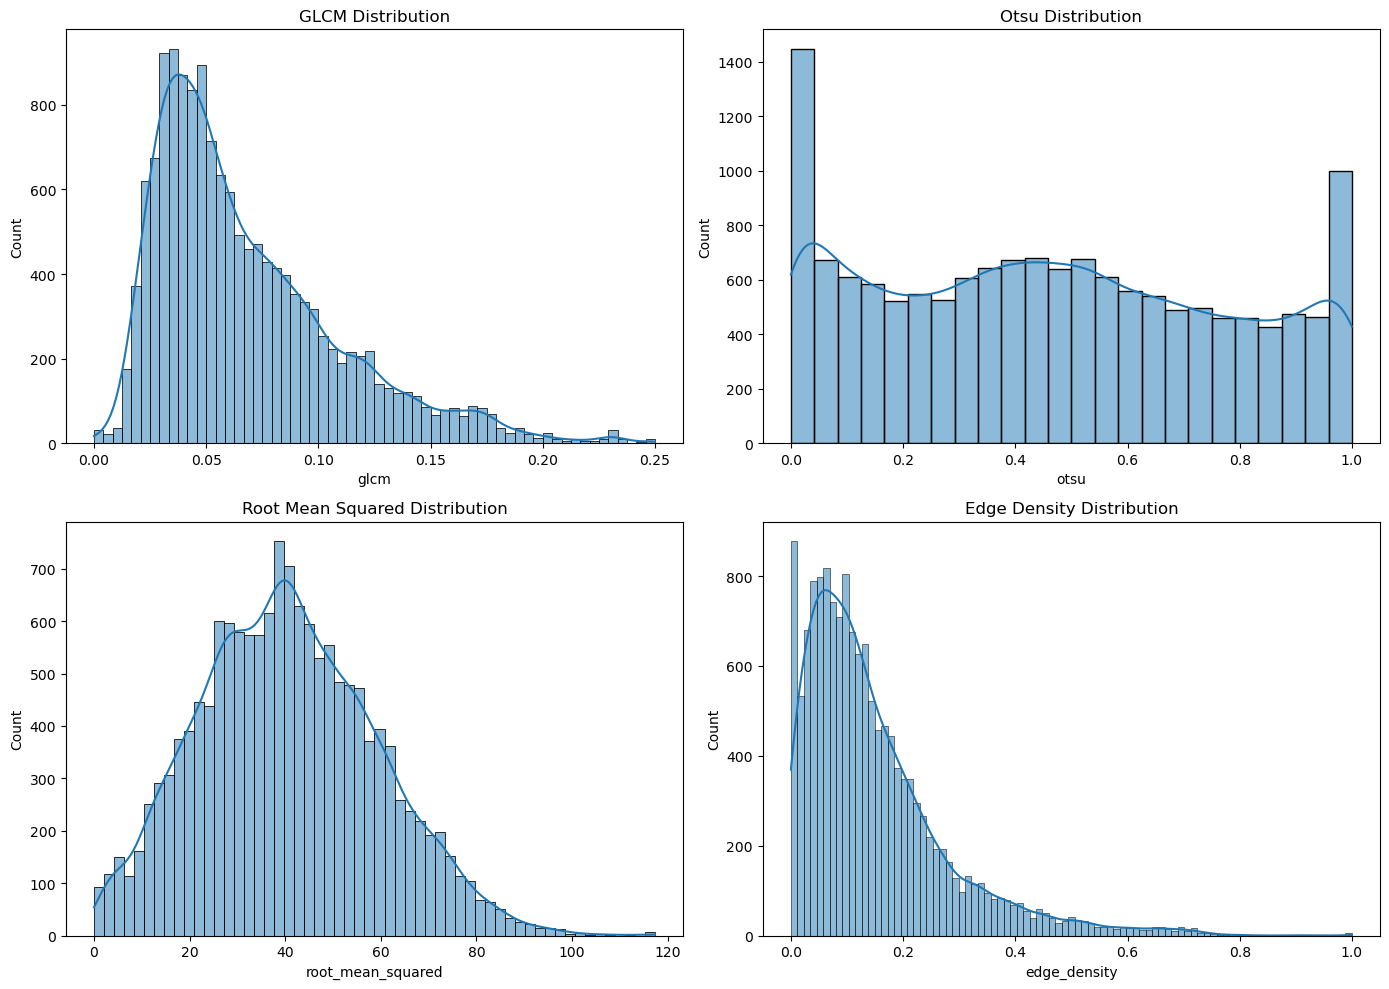

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(homogeneities_df['glcm'], kde=True, ax=ax[0, 0])
ax[0, 0].set_title('GLCM Distribution')

sns.histplot(homogeneities_df['otsu'], kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Otsu Distribution')

sns.histplot(homogeneities_df['root_mean_squared'], kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Root Mean Squared Distribution')

sns.histplot(homogeneities_df['edge_density'], kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Edge Density Distribution')

plt.tight_layout()
plt.show()